In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [4]:
data = pd.read_csv("dataset_mood_smartphone.csv", index_col=0)              # Load the data                                                    
data[['date', 'time']] = data['time'].str.split(' ', expand=True) 
data.head()

,id,time,variable,value,date
1,AS14.01,13:00:00.000,mood,6.0,2014-02-26
2,AS14.01,15:00:00.000,mood,6.0,2014-02-26
3,AS14.01,18:00:00.000,mood,6.0,2014-02-26
4,AS14.01,21:00:00.000,mood,7.0,2014-02-26
5,AS14.01,09:00:00.000,mood,6.0,2014-02-27


In [5]:
data_mood = data[data["variable"] == "mood" ]                               # Select the rows where the variable is "mood"
result_mood = data_mood.groupby(['id', 'date']).agg({'value': 'mean'}).reset_index()   # Group by id and date and calculate the mean of the value column

In [6]:
result_mood.describe()

,value
count,1268.000000
mean,6.990063
std,0.736465
min,3.000000
25%,6.600000
50%,7.000000
75%,7.500000
max,9.333333


In [7]:
unique_dates = result_mood['date'].unique()  # Get the unique dates
unique_ids = result_mood["id"].unique()      # Get the unique ids
print(len(unique_dates))                # Print the number of unique dates
print(len(unique_ids))                  # Print the number of unique ids

98
27


<Axes: xlabel='value', ylabel='Count'>

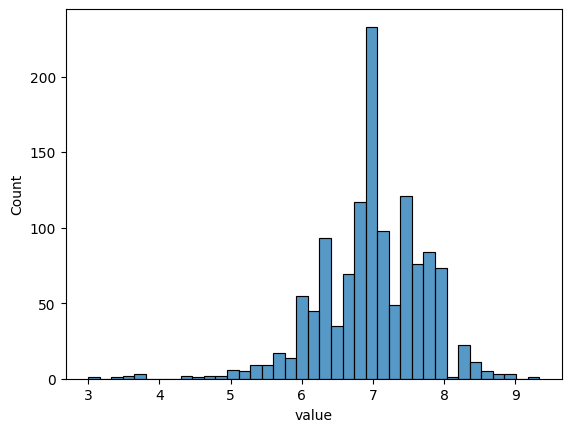

In [8]:
sns.histplot(result_mood, x="value")  # Create a histogram of the values

In [9]:
data["variable"].unique()

array(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather'],
      dtype=object)

In [115]:
data_arousal = data[data["variable"] == "circumplex.arousal"]
data_screen = data[data["variable"] == "screen"]                # Select the rows where the variable is "screen"
data_valence = data[data["variable"] == "circumplex.valence"]   # Select the rows where the variable is "circumplex.valence"
data_activity = data[data["variable"] == "activity"]            # Select the rows where the variable is "activity"  
data_call = data[data["variable"] == "call"]
data_sms = data[data["variable"] == "sms"]
data_built_in = data[data["variable"] == "appCat.builtin"]  
data_communication = data[data["variable"] == "appCat.communication"]
data_entertainment = data[data["variable"] == "appCat.entertainment"]
data_finance = data[data["variable"] == "appCat.finance"]
data_game = data[data["variable"] == "appCat.game"]
data_office = data[data["variable"] == "appCat.office"]
data_other = data[data["variable"] == "appCat.other"]
data_social = data[data["variable"] == "appCat.social"]
data_travel = data[data["variable"] == "appCat.travel"]
data_unknown = data[data["variable"] == "appCat.unknown"]
data_utility = data[data["variable"] == "appCat.utilities"]
data_weather = data[data["variable"] == "appCat.weather"]
data_built_in.loc[data_built_in['value'] < 0, 'value'] = data_built_in.loc[data_built_in['value'] < 0, 'value'].abs()

In [116]:
result_screen = data_screen.groupby(['id', 'date']).agg({'value': 'sum'}).reset_index().rename(columns={'value': 'screen_time'})
result_arousal = data_arousal.groupby(['id', 'date']).agg({'value': 'mean'}).reset_index().rename(columns={'value': 'arousal_value'})
result_valence = data_valence.groupby(['id', 'date']).agg({'value': 'mean'}).reset_index().rename(columns={'value': 'valence_value'})
result_activity = data_activity.groupby(['id', 'date']).agg({"value": "mean"}).reset_index().rename(columns={'value': 'activity_time'})
result_call = data_call.groupby(['id', 'date']).agg({"value":"sum"}).reset_index().rename(columns={'value': 'call_time'})
result_sms = data_sms.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'sms_time'})
result_built_in = data_built_in.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'built_in_time'})
result_communication = data_communication.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'communication_time'})
result_entertainment = data_entertainment.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'entertainment_time'})
result_finance = data_finance.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'finance_time'})
result_game = data_game.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'game_time'})
result_office = data_office.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'office_time'})
result_other = data_other.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'other_time'})
result_social = data_social.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'social_time'})
result_travel = data_travel.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'travel_time'})    
result_unknown = data_unknown.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'unknown_time'})
result_utility = data_utility.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'utility_time'})
result_weather = data_weather.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'weather_time'})

In [117]:
result_call.head()

,id,date,call_time
0,AS14.01,2014-02-17,2.0
1,AS14.01,2014-02-18,1.0
2,AS14.01,2014-02-19,7.0
3,AS14.01,2014-02-20,2.0
4,AS14.01,2014-02-22,2.0


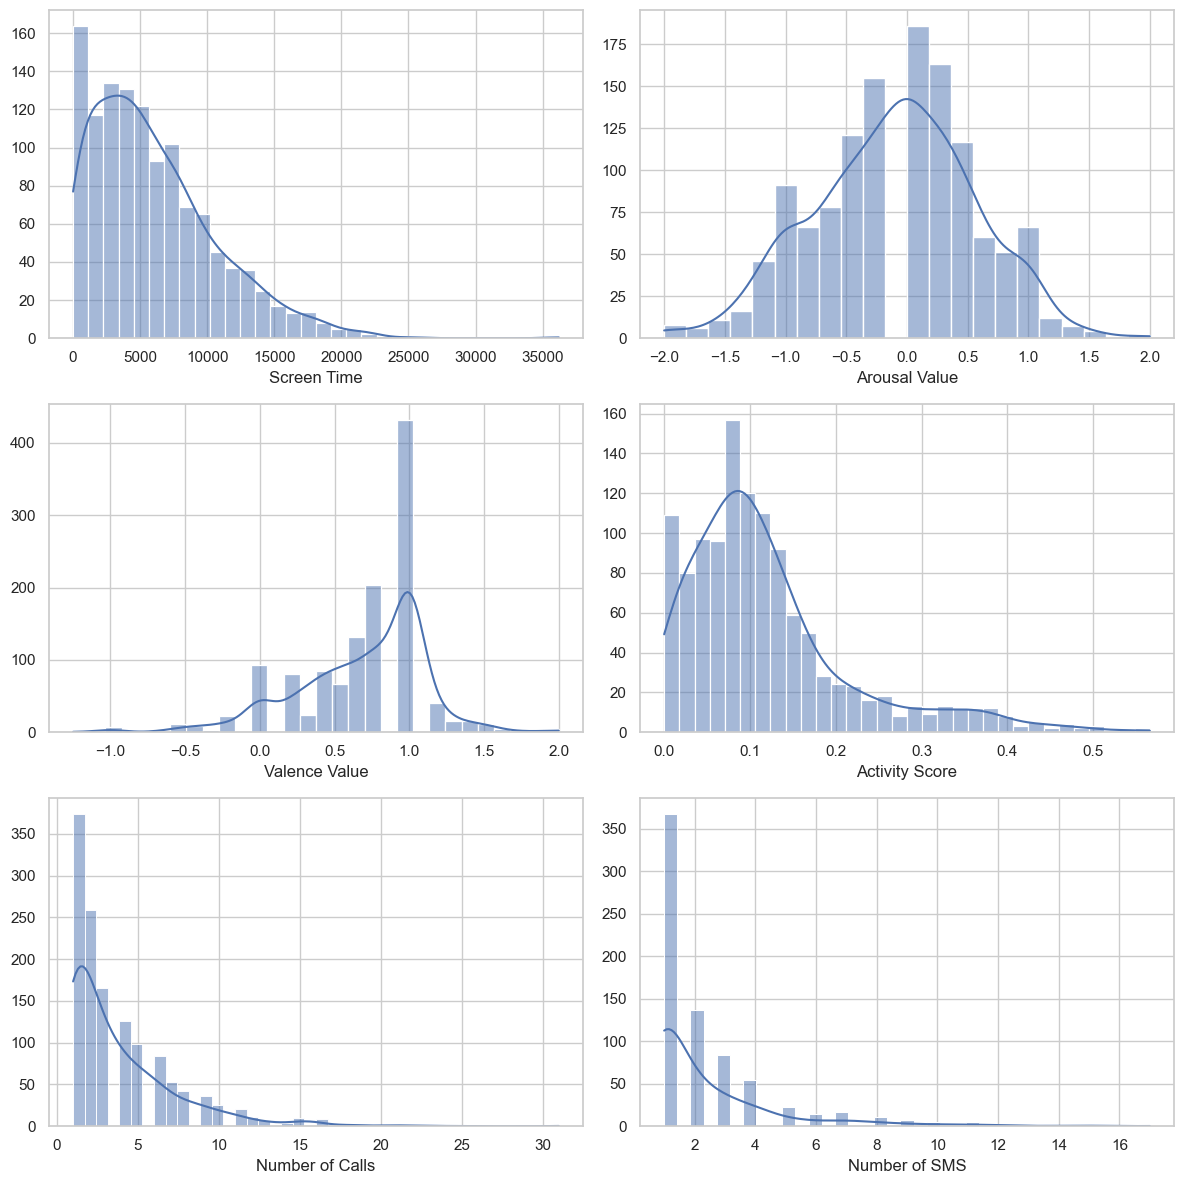

In [118]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Plotting histograms for each activity
sns.histplot(data=result_screen, x="screen_time", label="Screen", kde=True, ax=axes[0])
axes[0].set_xlabel("Screen Time")

sns.histplot(data=result_arousal, x="arousal_value", label="Arousal", kde=True, ax=axes[1])
axes[1].set_xlabel("Arousal Value")

sns.histplot(data=result_valence, x="valence_value", label="Valence", kde=True, ax=axes[2])
axes[2].set_xlabel("Valence Value")

sns.histplot(data=result_activity, x="activity_time", label="Activity", kde=True, ax=axes[3])
axes[3].set_xlabel("Activity Score")

sns.histplot(data=result_call, x="call_time", label="Call", kde=True, ax=axes[4])
axes[4].set_xlabel("Number of Calls")

sns.histplot(data=result_sms, x="sms_time", label="SMS", kde=True, ax=axes[5])
axes[5].set_xlabel("Number of SMS")

# Removing y-axis label to save space
for ax in axes:
    ax.set_ylabel("")

plt.tight_layout()
plt.show()



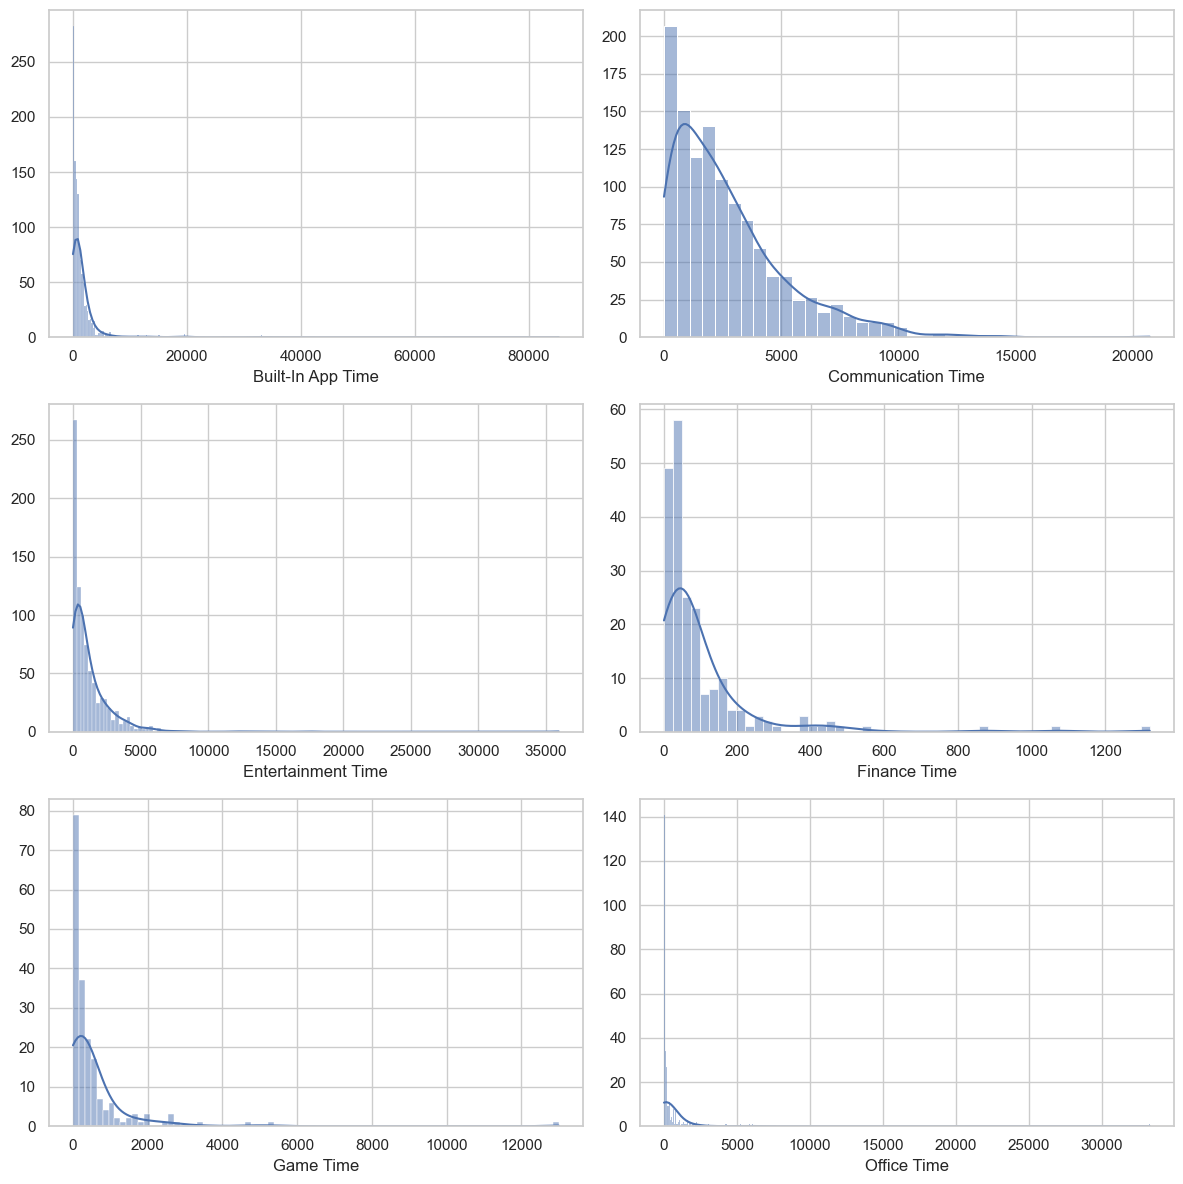

In [119]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Plotting histograms for each activity
sns.histplot(data=result_built_in, x="built_in_time", label="Built-In App", kde=True, ax=axes[0])
axes[0].set_xlabel("Built-In App Time")

sns.histplot(data=result_communication, x="communication_time", label="Communication", kde=True, ax=axes[1])
axes[1].set_xlabel("Communication Time")

sns.histplot(data=result_entertainment, x="entertainment_time", label="Entertainment", kde=True, ax=axes[2])
axes[2].set_xlabel("Entertainment Time")

sns.histplot(data=result_finance, x="finance_time", label="Finance", kde=True, ax=axes[3])
axes[3].set_xlabel("Finance Time")

sns.histplot(data=result_game, x="game_time", label="Game", kde=True, ax=axes[4])
axes[4].set_xlabel("Game Time")

sns.histplot(data=result_office, x="office_time", label="Office", kde=True, ax=axes[5])
axes[5].set_xlabel("Office Time")

# Removing y-axis label to save space
for ax in axes:
    ax.set_ylabel("")

plt.tight_layout()
plt.show()


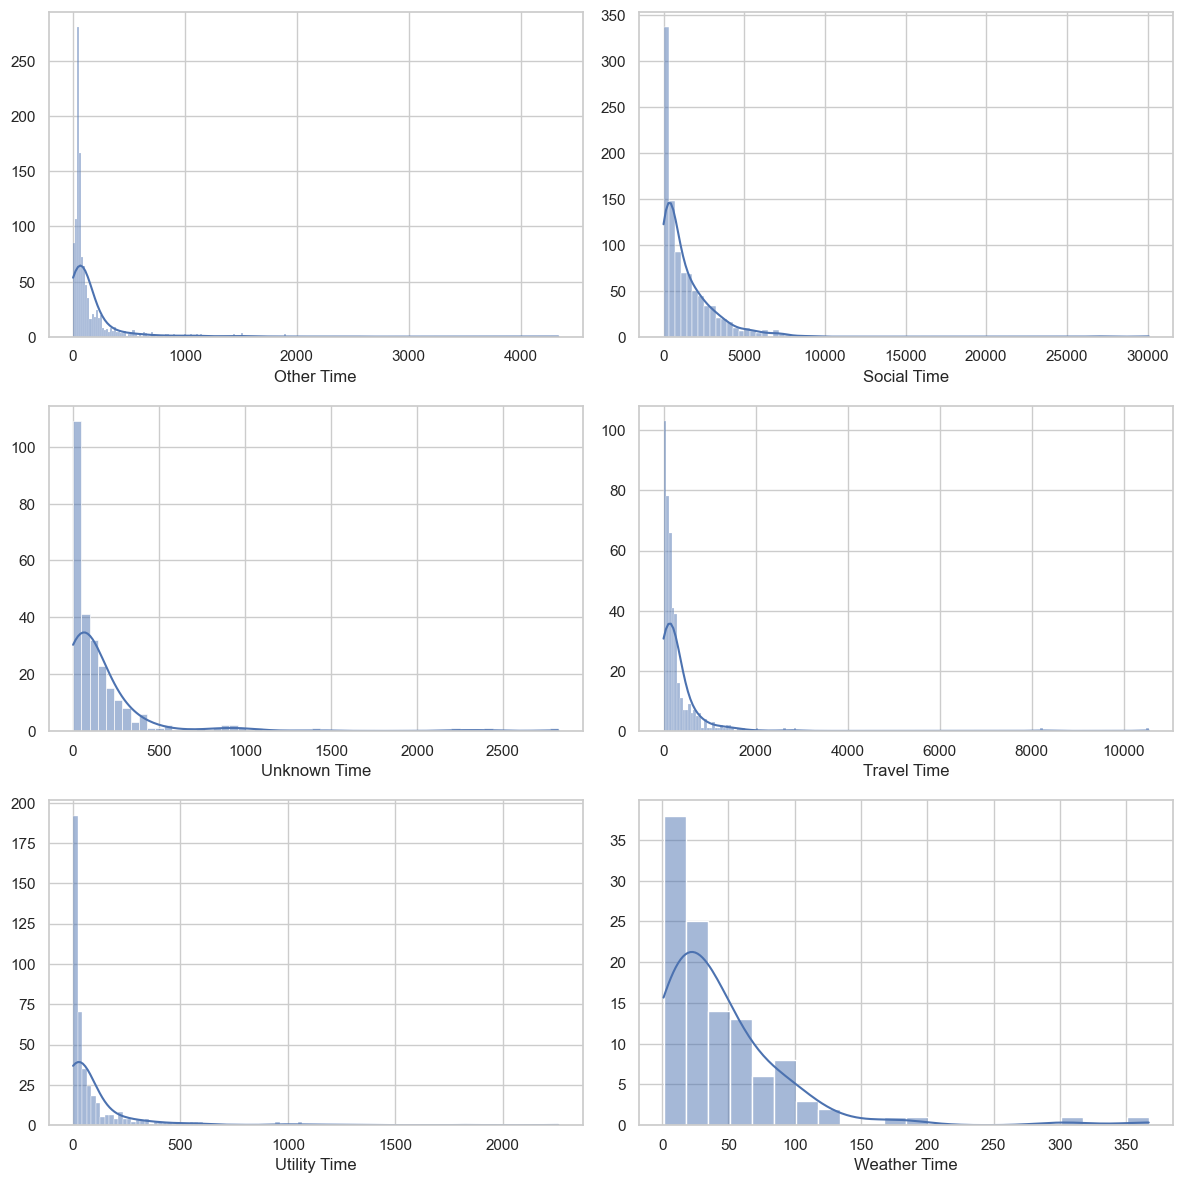

In [120]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Plotting histograms for each activity
sns.histplot(data=result_other, x="other_time", label="Other", kde=True, ax=axes[0])
axes[0].set_xlabel("Other Time")

sns.histplot(data=result_social, x="social_time", label="Social", kde=True, ax=axes[1])
axes[1].set_xlabel("Social Time")

sns.histplot(data=result_unknown, x="unknown_time", label="Unknown", kde=True, ax=axes[2])
axes[2].set_xlabel("Unknown Time")

sns.histplot(data=result_travel, x="travel_time", label="Travel", kde=True, ax=axes[3])
axes[3].set_xlabel("Travel Time")

sns.histplot(data=result_utility, x="utility_time", label="Utility", kde=True, ax=axes[4])
axes[4].set_xlabel("Utility Time")

sns.histplot(data=result_weather, x="weather_time", label="Weather", kde=True, ax=axes[5])
axes[5].set_xlabel("Weather Time")

# Removing y-axis label to save space
for ax in axes:
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

In [121]:
result_combined = result_screen.join(result_arousal.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_valence.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_activity.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_call.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_sms.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_built_in.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_communication.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_entertainment.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_finance.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_game.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_office.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_other.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_social.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_travel.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_unknown.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_utility.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_weather.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_mood.set_index(['id', 'date']), on=['id', 'date'])

In [167]:
final_df = result_combined.drop(columns=['id', 'date'])     # Drop the id column

In [168]:
value_counts = data['variable'].value_counts()

<Axes: ylabel='count'>

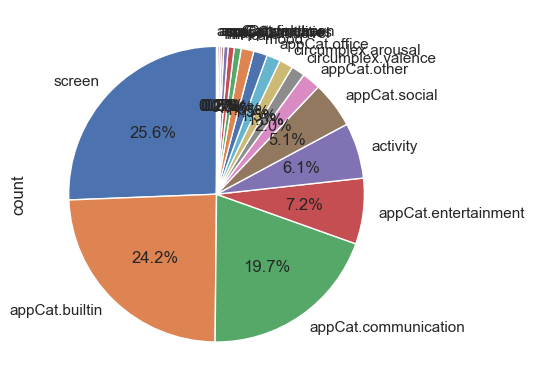

In [169]:
# Plot a pie chart
value_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)

In [170]:
final_df = final_df.dropna(subset=['value'])
null_counts = final_df.isnull().sum()

In [171]:
final_df.describe()

,screen_time,arousal_value,valence_value,activity_time,call_time,sms_time,built_in_time,communication_time,entertainment_time,finance_time,game_time,office_time,other_time,social_time,travel_time,unknown_time,utility_time,weather_time,value
count,1168.000000,1168.000000,1166.000000,1135.000000,709.000000,404.000000,1156.000000,1145.000000,822.000000,206.000000,189.00000,270.000000,1103.000000,961.000000,418.000000,255.000000,424.000000,111.000000,1168.000000
mean,6081.640869,-0.122617,0.693954,0.120366,3.916784,2.433168,1571.895938,2740.680086,1222.043478,99.101126,522.55564,450.342019,177.770704,1414.450565,308.017969,154.974224,107.278922,45.531324,6.995648
std,4687.828463,0.659736,0.432859,0.096596,3.582382,2.439946,3918.931927,2462.317267,1946.917652,155.712625,1142.12511,2143.917700,397.701843,1990.661478,729.220279,290.242294,236.212283,53.742546,0.745633
min,0.462000,-2.000000,-1.250000,0.000000,1.000000,1.000000,0.914000,1.095000,1.014000,1.004000,1.01000,0.044000,5.014000,0.725000,0.080000,0.111000,1.002000,1.007000,3.000000
25%,2499.812751,-0.600000,0.400000,0.057148,1.000000,1.000000,269.707750,879.515000,203.022500,27.204000,83.54500,17.091250,44.876000,214.171000,62.317250,21.860000,8.981250,12.667000,6.600000
50%,5076.514499,0.000000,0.800000,0.097098,3.000000,1.000000,780.920000,2107.479000,672.533500,49.461500,209.75000,71.470500,65.623000,767.060000,143.343000,66.477000,26.732000,30.084000,7.000000
75%,8617.591749,0.333333,1.000000,0.148462,5.000000,3.000000,1581.426500,3834.645000,1603.332750,101.130000,531.71700,264.146500,140.585500,2008.184000,289.521250,174.963000,88.641750,55.792500,7.500000
max,36204.105001,2.000000,2.000000,0.549430,31.000000,17.000000,85229.812000,20718.749000,35937.645000,1321.104000,12996.49500,33283.021000,4335.307000,30073.421000,10548.116000,2821.547000,2257.626000,366.937000,9.333333


<Axes: >

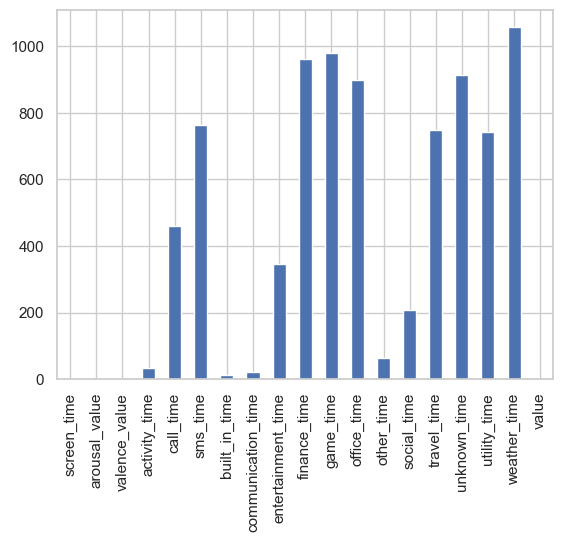

In [172]:
null_counts.plot(kind='bar')

In [173]:
final_df = final_df.fillna(final_df.mean())

In [174]:
final_df.head()

,screen_time,arousal_value,valence_value,activity_time,call_time,sms_time,built_in_time,communication_time,entertainment_time,finance_time,game_time,office_time,other_time,social_time,travel_time,unknown_time,utility_time,weather_time,value
1,17978.907000,0.2,0.2,0.134050,6.000000,2.433168,3139.218,6280.890,1007.456,49.544,522.55564,172.206000,239.751,4508.500,915.445000,154.974224,598.754,45.531324,6.20
2,6142.161000,0.6,0.5,0.236880,3.000000,1.000000,731.429,4962.918,93.324,21.076,522.55564,450.342019,98.143,439.632,37.305000,154.974224,117.621,45.531324,6.40
3,6773.832001,0.2,0.8,0.142741,3.916784,2.433168,1286.246,5237.319,94.346,43.403,522.55564,450.342019,72.823,900.839,308.017969,154.974224,30.086,30.386000,6.80
4,15047.351001,0.8,0.0,0.078961,10.000000,2.433168,866.956,9270.629,976.971,34.106,522.55564,3.010000,66.558,3223.626,419.805000,154.974224,178.732,45.531324,6.00
5,21475.354999,0.5,0.5,0.098374,3.916784,1.000000,1032.768,10276.751,68.206,43.054,522.55564,450.342019,178.819,1919.471,308.017969,235.223000,222.893,45.531324,6.75


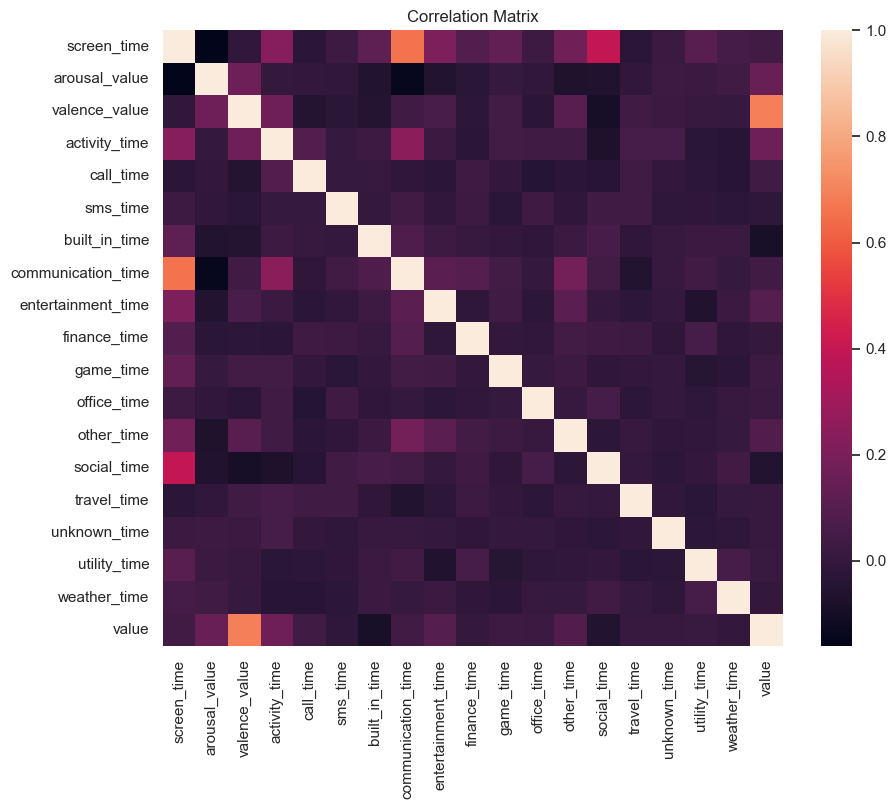

In [175]:
# Calculate correlation matrix
corr_matrix = final_df .corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix)
plt.title('Correlation Matrix')
plt.show()

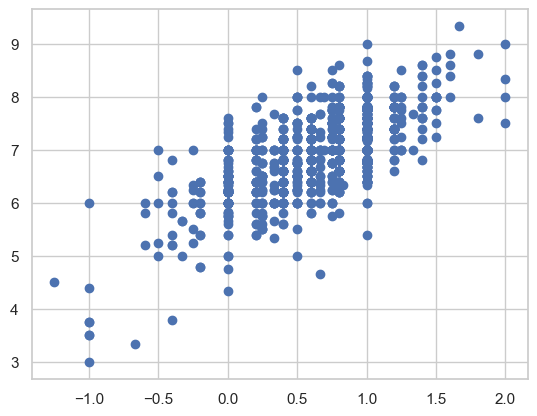

In [176]:
plt.scatter(final_df['valence_value'], final_df['value'])

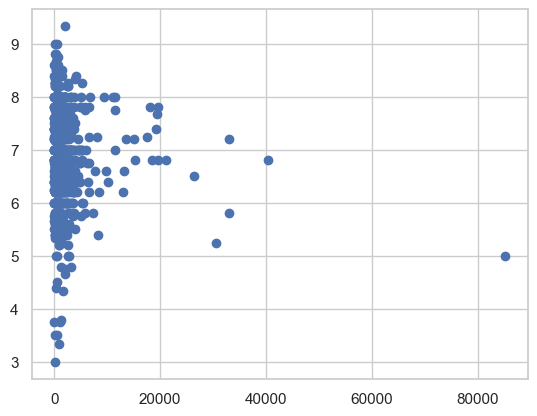

In [177]:
plt.scatter(final_df['built_in_time'], final_df['value'])

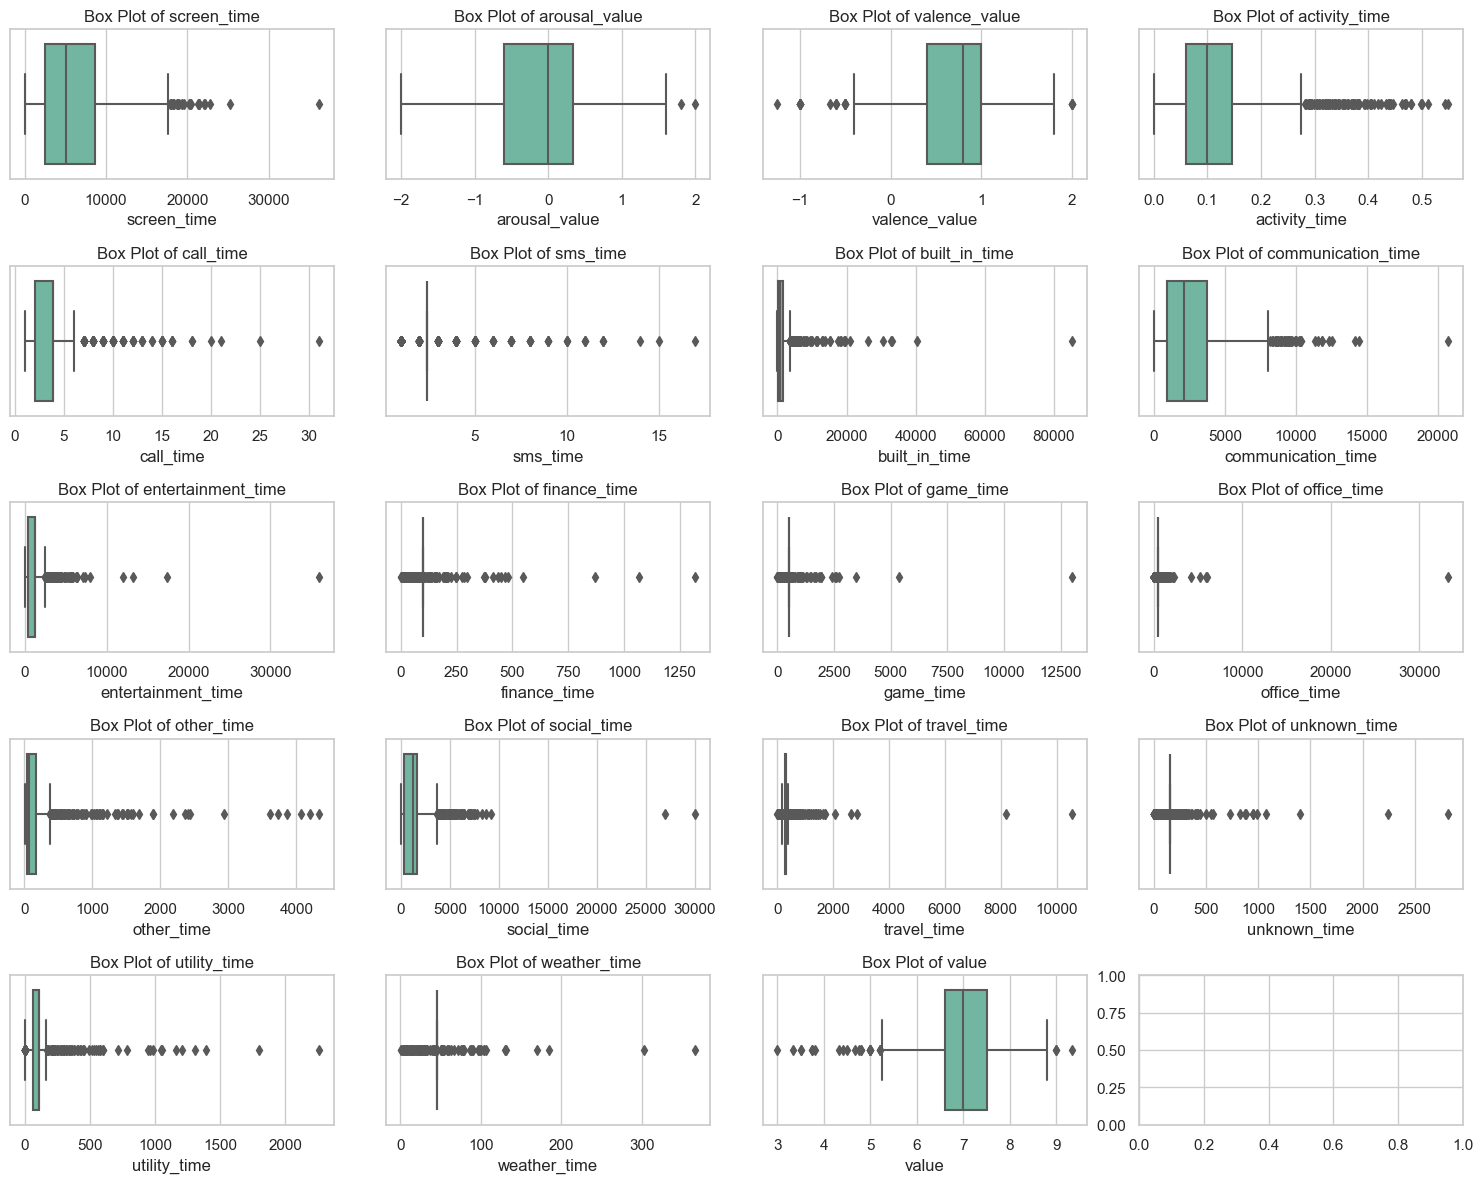

In [178]:
# Create multiple subplots for each column
fig, axes = plt.subplots(5, 4, figsize=(15, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column in a separate subplot
for i, column in enumerate(final_df.columns):
    sns.boxplot(x=final_df[column], ax=axes[i], palette="Set2")
    axes[i].set_title(f'Box Plot of {column}')

# Hide any unused subplots
# for j in range(len(df.columns), len(axes)):
#     axes[j].axis('off')

plt.tight_layout()
plt.show()

In [179]:
final_df.skew().sort_values(ascending=False)

office_time           28.270196
game_time             19.001072
travel_time           16.785154
built_in_time         11.682998
unknown_time          11.628350
finance_time          10.993283
weather_time          10.656788
entertainment_time    10.250447
utility_time           7.828208
social_time            6.745080
other_time             6.589836
sms_time               4.486821
call_time              2.931363
activity_time          1.614003
communication_time     1.609781
screen_time            1.132220
arousal_value         -0.125044
value                 -0.840164
valence_value         -0.865423
dtype: float64

In [180]:
from sklearn.preprocessing import PowerTransformer

In [181]:
def yeojohntrans(feature):   # function to apply transformer and check the distribution with histogram and kdeplot
    
    yeojohnTr = PowerTransformer(standardize=True)   # not using method attribute as yeo-johnson is the default

    # plt.figure(figsize=(15,6))
    # plt.subplot(1,2,1)
    # plt.title("Distribution before Transformation", fontsize=15)
    # sns.histplot(final_df[feature], kde=True, color="red")
    # plt.subplot(1,2,2)
    
    df_yeojohn = pd.DataFrame(yeojohnTr.fit_transform(final_df[feature].values.reshape(-1,1)))
    # plt.title("Distribution after Transformation", fontsize=15)
    # sns.histplot(df_yeojohn,bins=20, kde=True , legend=False)
    # plt.xlabel(feature)
    # plt.show()
    
    print(f"Skewness {round(df_yeojohn.skew()[0],2)} after Yeo-johnson transformation.")
    
    return df_yeojohn
    
for column in final_df.columns:
    if column != 'value':
        final_df[column] = yeojohntrans(column)
    

Skewness -0.12 after Yeo-johnson transformation.
Skewness 0.01 after Yeo-johnson transformation.
Skewness 0.04 after Yeo-johnson transformation.
Skewness 0.1 after Yeo-johnson transformation.
Skewness -0.0 after Yeo-johnson transformation.
Skewness -0.1 after Yeo-johnson transformation.
Skewness 0.04 after Yeo-johnson transformation.
Skewness -0.08 after Yeo-johnson transformation.
Skewness 0.05 after Yeo-johnson transformation.
Skewness 0.68 after Yeo-johnson transformation.
Skewness 1.39 after Yeo-johnson transformation.
Skewness 1.06 after Yeo-johnson transformation.
Skewness -0.03 after Yeo-johnson transformation.
Skewness -0.04 after Yeo-johnson transformation.
Skewness 0.58 after Yeo-johnson transformation.
Skewness 0.84 after Yeo-johnson transformation.
Skewness 0.2 after Yeo-johnson transformation.
Skewness 1.42 after Yeo-johnson transformation.


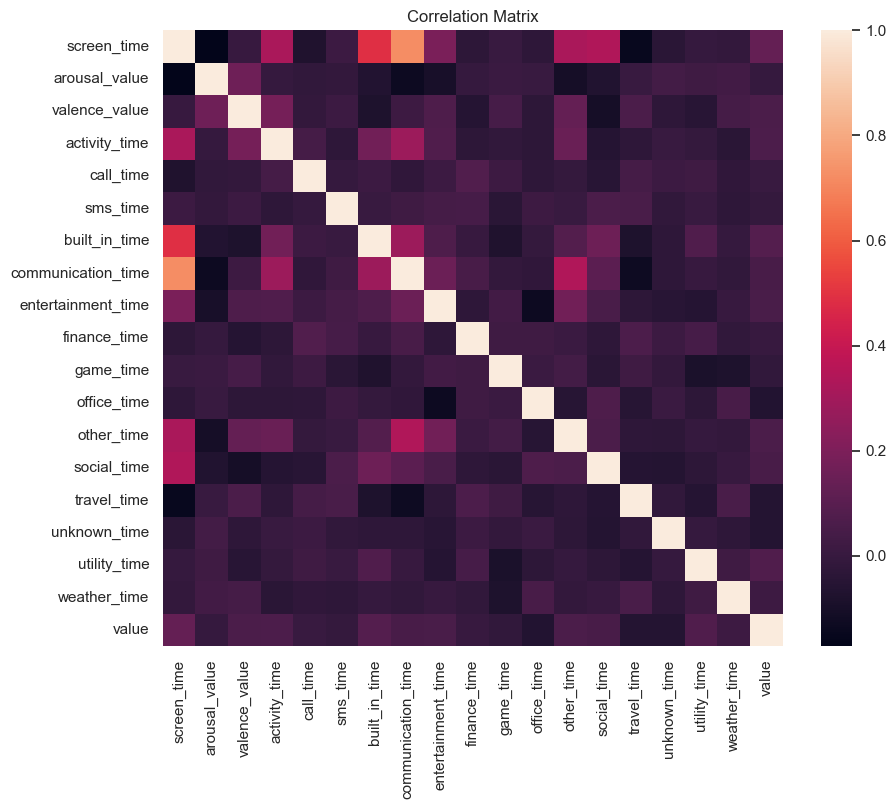

In [182]:
# Calculate correlation matrix
corr_matrix = final_df .corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix)
plt.title('Correlation Matrix')
plt.show()

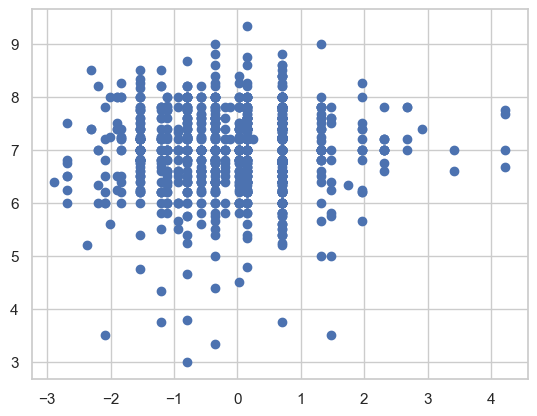

In [190]:
plt.scatter( final_df['valence_value'], final_df['value'])